## Feature selection based on "****average feature importance****" to reduce computational cost

During the second phase, I encountered suboptimal outcomes for specific attack categories, notably Infiltration and WebAttack. This was primarily attributed to the insufficient volume of data available for these particular attack types. Consequently, in the  third phase, I undertook a strategic approach by leveraging the **CSE-CIC-IDS2018 and CIC-DDoS2019 datasets**. The objective was to reinforce the database's representation of certain attacks, namely BruteForce, Bot, WebAttack, and Infiltration. To align the distribution, I rounded up the number of instances for these attacks to match the count of the other classes.

**For BruteForce, an augmentation of 28,233 instances was introduced, while Bot saw the addition of 30,607 instances. Similarly, Infiltration was enriched by an inclusion of 30,993 records from the CSE-CIC-IDS2018 dataset. To address the scarcity of WebAttack instances in the CSE-CIC-IDS2018 dataset, 30,563 instances were integrated from the CIC-DDoS2019 dataset.**

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

### Read the sampled CICIDS2017 dataset

In [10]:
df = pd.read_csv('./data/CICIDS2017_20Percent_resampled.csv')

In [11]:
df

,DestinationPort,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,538750,3,6,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DoS
1,53580,74,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
2,53,33686,2,2,64,248,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
3,80,5313019,3,1,12,0,6,0,4.000000,3.464102,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
4,53,23299,1,1,49,114,49,49,49.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686536,80,5386626,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686537,80,5487373,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686538,80,5621517,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686539,80,5580559,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack


### Preprocessing (normalization and padding values)

In [12]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [13]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [14]:
X_train.shape

(549232, 77)

In [15]:
pd.Series(y_train).value_counts()

4    363694
2     60909
5     25429
1     24800
0     24800
6     24800
3     24800
dtype: int64

**Corresponding Attack Types:**  
0 Bot   
3 Infiltration          
6 WebAttack    
1 BruteForce                 
5 PortScan        
2 DoS      
4 Normaltraffic     



## Machine learning model training
### Training four base learners: decision tree, random forest, extra trees, XGBoost

### Decision tree training and prediction

Accuracy of DT: 0.9966061947869405
Precision of DT: 0.9966022008292584
Recall of DT: 0.9966061947869405
F1-score of DT: 0.9966040323147797
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       1.00      1.00      1.00    137309



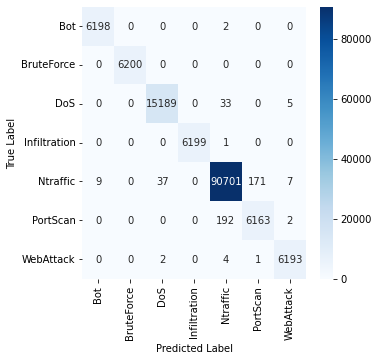

In [17]:
# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Evaluate the model
dt_score = dt.score(X_test, y_test)
y_predict = dt.predict(X_test)
y_true = y_test
print('Accuracy of DT: ' + str(dt_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [18]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

### Random Forest training and prediction

Accuracy of RF: 0.996963054133378
Precision of RF: 0.996999013839491
Recall of RF: 0.996963054133378
F1-score of RF: 0.9969699913980393
              precision    recall  f1-score   support

         Bot       0.99      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      0.99      0.99     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      1.00      0.99      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      1.00      1.00    137309
weighted avg       1.00      1.00      1.00    137309



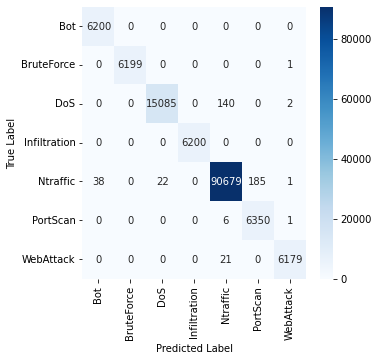

In [20]:
# Fit the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate the model
rf_score = rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
y_true = y_test
print('Accuracy of RF: ' + str(rf_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [21]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

### Extra trees training and prediction

Accuracy of ET: 0.9966134776307453
Precision of ET: 0.9966131821717995
Recall of ET: 0.9966134776307453
F1-score of ET: 0.996613309650742
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      1.00      1.00    137309



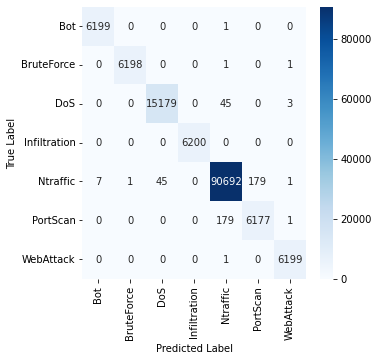

In [22]:
# Fit the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=0)
et.fit(X_train, y_train)

# Evaluate the model
et_score = et.score(X_test, y_test)
y_predict = et.predict(X_test)
y_true = y_test
print('Accuracy of ET: ' + str(et_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [23]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### XGboost training and prediction

Accuracy of XGBoost: 0.9938459969849026
Precision of XGBoost: 0.9939306110035474
Recall of XGBoost: 0.9938459969849026
F1-score of XGBoost: 0.993859198527236
              precision    recall  f1-score   support

         Bot       0.96      1.00      0.98      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      0.99      0.99     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.99      0.98      0.98      6200

    accuracy                           0.99    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       0.99      0.99      0.99    137309



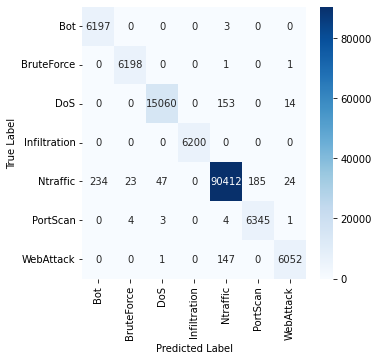

In [24]:
# Fit the XGBoost classifier
xg = xgb.XGBClassifier(n_estimators=10)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print the classification report
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap
cm = confusion_matrix(y_true, y_predict)

# Rename the class labels in the confusion matrix
cm_renamed = cm.copy()
for i in range(len(target_names)):
    for j in range(len(target_names)):
        cm_renamed[i][j] = cm[target_names.index(target_names[i])][target_names.index(target_names[j])]

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_renamed, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [26]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,2,2,2,2
4,4,4,4,4


In [27]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [28]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [29]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9966134776307453
Precision of Stacking: 0.9966091328837129
Recall of Stacking: 0.9966134776307453
F1-score of Stacking: 0.9966111139892795
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       1.00      1.00      1.00    137309



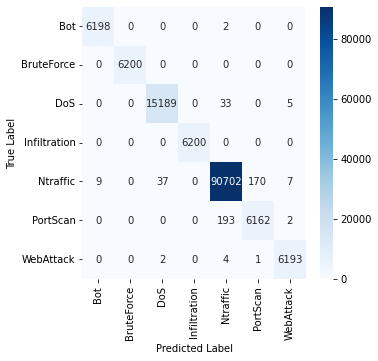

Execution Time: 55.49759888648987 seconds


In [30]:
import time

# Record the starting time
start_time = time.time()
# Fit the XGBClassifier for stacking
stk = xgb.XGBClassifier().fit(x_train, y_train)

# Make predictions and evaluate the model
y_predict = stk.predict(x_test)
y_true = y_test
stk_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: ' + str(stk_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: ' + str(precision))
print('Recall of Stacking: ' + str(recall))
print('F1-score of Stacking: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")


## Feature Selection

### Feature importance

In [31]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [32]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [33]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.097, 'DestinationPort'), (0.0961, 'Bwd_Packet_Length_Std'), (0.0539, 'Active_Min'), (0.0535, 'Avg_Bwd_Segment_Size'), (0.0486, 'PSH_Flag_Count'), (0.0413, 'Average_Packet_Size'), (0.0354, 'Init_Win_bytes_backward'), (0.0352, 'Min_Packet_Length'), (0.0306, 'Bwd_Packet_Length_Mean'), (0.0279, 'Idle_Min'), (0.0264, 'Fwd_IAT_Std'), (0.026, 'Init_Win_bytes_forward'), (0.0251, 'Flow_Duration'), (0.0247, 'Packet_Length_Std'), (0.0235, 'Bwd_Packet_Length_Max'), (0.0192, 'Fwd_IAT_Min'), (0.0185, 'Bwd_Packet_Length_Min'), (0.0157, 'Packet_Length_Mean'), (0.0152, 'Fwd_Packet_Length_Std'), (0.0144, 'Bwd_Packets_s'), (0.0133, 'Flow_Packets_s'), (0.0123, 'Packet_Length_Variance'), (0.0117, 'Fwd_Packet_Length_Min'), (0.0112, 'Max_Packet_Length'), (0.0106, 'Total_Length_of_Fwd_Packets'), (0.0099, 'ACK_Flag_Count'), (0.0097, 'Subflow_Fwd_Bytes'), (0.009, 'Flow_IAT_Min'), (0.0086, 'Fwd_Packet_Length_Mean'), (0.0086, 'Fwd_Packet_Length_Max'), (0.0084, 'Fwd_IAT_Max'), (

In [34]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [35]:
len(f_list)

77

In [36]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break 

In [37]:
X_fs = df[fs].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [39]:
X_train.shape

(549232, 39)

In [40]:
pd.Series(y_train).value_counts()

4    363694
2     60909
5     25429
1     24800
0     24800
6     24800
3     24800
dtype: int64

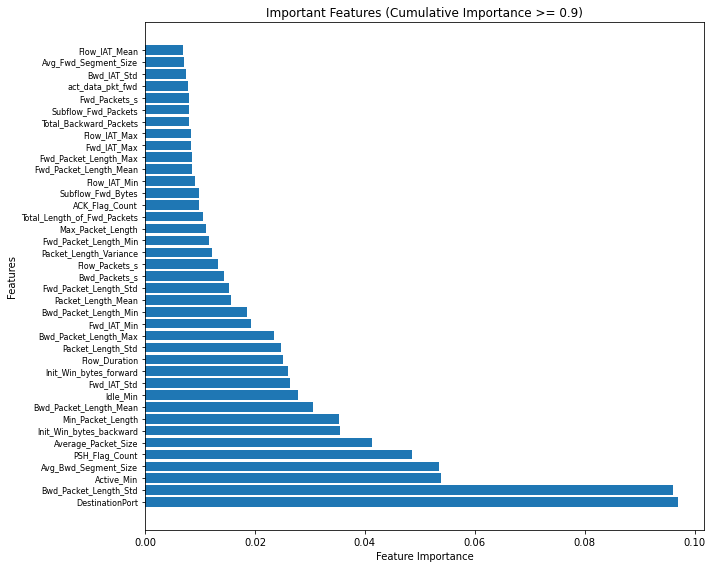

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

# Calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature) / 4

# Get the feature names
feature_names = df.drop(['Label'], axis=1).columns.values

# Sort the features based on their score
sorted_features = sorted(zip(avg_feature, feature_names), reverse=True)

# Extract the sorted scores and feature names
sorted_scores, sorted_names = zip(*sorted_features)

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_scores)

# Find the index where cumulative importance reaches 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Extract the important features
important_features = sorted_names[:index+1]
important_scores = sorted_scores[:index+1]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(important_features)), important_scores, align='center')
plt.yticks(range(len(important_features)), important_features, fontsize=8)
plt.xlabel('Feature Importance', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.title('Important Features (Cumulative Importance >= 0.9)', fontsize=12)
plt.tight_layout()  # Adjust spacing between the bars

plt.show()

In [42]:
from tabulate import tabulate

# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

# Calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature) / 4

# Get the feature names
feature_names = df.drop(['Label'], axis=1).columns.values

# Sort the features based on their score
sorted_features = sorted(zip(avg_feature, feature_names), reverse=True)

# Extract the sorted scores and feature names
sorted_scores, sorted_names = zip(*sorted_features)

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_scores)

# Find the index where cumulative importance reaches 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Extract the important features and their corresponding scores
important_features = sorted_names[:index+1]
important_scores = sorted_scores[:index+1]

# Calculate the weights for the important features
total_importance = np.sum(important_scores)
weights = important_scores / total_importance

# Create a list of lists for the table
table_data = [[feature, weight] for feature, weight in zip(important_features, weights)]

# Define the table headers
headers = ["Feature", "Weight"]

# Print the table
table = tabulate(table_data, headers, tablefmt="fancy_grid")
print(table)


╒═════════════════════════════╤════════════╕
│ Feature                     │     Weight │
╞═════════════════════════════╪════════════╡
│ DestinationPort             │ 0.107394   │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Std       │ 0.106477   │
├─────────────────────────────┼────────────┤
│ Active_Min                  │ 0.0596576  │
├─────────────────────────────┼────────────┤
│ Avg_Bwd_Segment_Size        │ 0.059245   │
├─────────────────────────────┼────────────┤
│ PSH_Flag_Count              │ 0.0538702  │
├─────────────────────────────┼────────────┤
│ Average_Packet_Size         │ 0.045761   │
├─────────────────────────────┼────────────┤
│ Init_Win_bytes_backward     │ 0.0392298  │
├─────────────────────────────┼────────────┤
│ Min_Packet_Length           │ 0.0389914  │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Mean      │ 0.0338724  │
├─────────────────────────────┼────────────┤
│ Idle_Min                    │ 0.0308671  │
├─────────

╒═════════════════════════════╤════════════╕
│ Feature                     │     Weight │
╞═════════════════════════════╪════════════╡
│ DestinationPort             │ 0.107394   │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Std       │ 0.106477   │
├─────────────────────────────┼────────────┤
│ Active_Min                  │ 0.0596576  │
├─────────────────────────────┼────────────┤
│ Avg_Bwd_Segment_Size        │ 0.059245   │
├─────────────────────────────┼────────────┤
│ PSH_Flag_Count              │ 0.0538702  │
├─────────────────────────────┼────────────┤
│ Average_Packet_Size         │ 0.045761   │
├─────────────────────────────┼────────────┤
│ Init_Win_bytes_backward     │ 0.0392298  │
├─────────────────────────────┼────────────┤
│ Min_Packet_Length           │ 0.0389914  │
├─────────────────────────────┼────────────┤
│ Bwd_Packet_Length_Mean      │ 0.0338724  │
├─────────────────────────────┼────────────┤
│ Idle_Min                    │ 0.0308671  │
├─────────

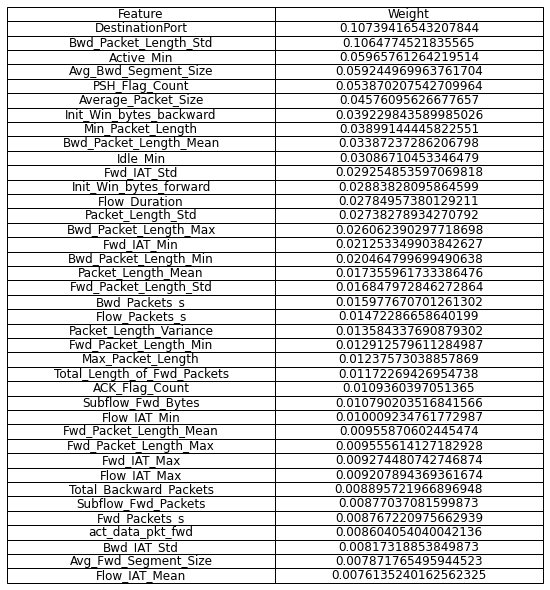

In [43]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Your code to calculate the important features and weights

# Create a list of lists for the table
table_data = [[feature, weight] for feature, weight in zip(important_features, weights)]

# Define the table headers
headers = ["Feature", "Weight"]

# Print the table
table_str = tabulate(table_data, headers, tablefmt="fancy_grid")
print(table_str)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.axis("off")

# Plot the table
table = ax.table(cellText=table_data, colLabels=headers, cellLoc="center", loc="center")

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Save the figure as a PDF
plt.savefig("table.pdf", bbox_inches="tight")

## Machine learning model training after feature selection

Accuracy of DT: 0.9966134776307453
Precision of DT: 0.99661006761229
Recall of DT: 0.9966134776307453
F1-score of DT: 0.9966116544943054
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       1.00      1.00      1.00    137309



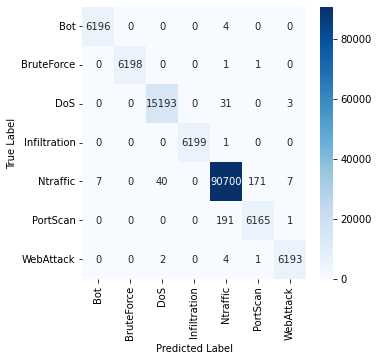

In [44]:
# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Evaluate the model
dt_score = dt.score(X_test, y_test)
y_predict = dt.predict(X_test)
y_true = y_test
print('Accuracy of DT: ' + str(dt_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [45]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9978734096089841
Precision of RF: 0.9979090719191911
Recall of RF: 0.9978734096089841
F1-score of RF: 0.9978819397570646
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       1.00      1.00      1.00    137309
weighted avg       1.00      1.00      1.00    137309



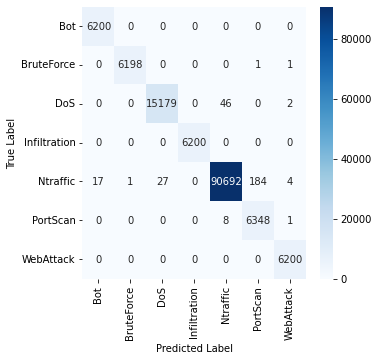

In [46]:
# Fit the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate the model
rf_score = rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
y_true = y_test
print('Accuracy of RF: ' + str(rf_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [47]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9966571746935744
Precision of ET: 0.9966576934976437
Recall of ET: 0.9966571746935744
F1-score of ET: 0.9966573719750021
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      1.00      1.00    137309
weighted avg       1.00      1.00      1.00    137309



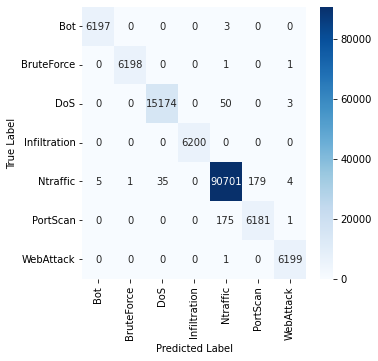

In [48]:
# Fit the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=0)
et.fit(X_train, y_train)

# Evaluate the model
et_score = et.score(X_test, y_test)
y_predict = et.predict(X_test)
y_true = y_test
print('Accuracy of ET: ' + str(et_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [49]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.993634794514562
Precision of XGBoost: 0.9937283850078796
Recall of XGBoost: 0.993634794514562
F1-score of XGBoost: 0.9936489521043045
              precision    recall  f1-score   support

         Bot       0.96      1.00      0.98      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      0.99      0.99     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       1.00      0.98      0.99      6200

    accuracy                           0.99    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       0.99      0.99      0.99    137309



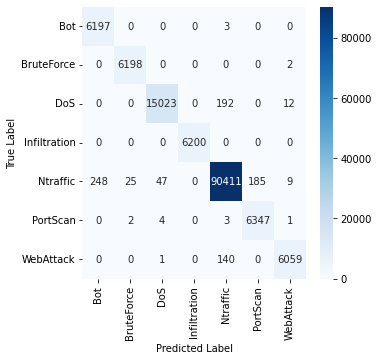

In [50]:
# Fit the XGBoost classifier
xg = xgb.XGBClassifier(n_estimators=10)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print the classification report
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap
cm = confusion_matrix(y_true, y_predict)

# Rename the class labels in the confusion matrix
cm_renamed = cm.copy()
for i in range(len(target_names)):
    for j in range(len(target_names)):
        cm_renamed[i][j] = cm[target_names.index(target_names[i])][target_names.index(target_names[j])]

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_renamed, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [51]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [52]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,2,2,2,2
4,4,4,4,4


In [53]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [54]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9966061947869405
Precision of Stacking: 0.996602405090667
Recall of Stacking: 0.9966061947869405
F1-score of Stacking: 0.9966041594666469
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      1.00      1.00     90925
    PortScan       0.97      0.97      0.97      6357
   WebAttack       1.00      1.00      1.00      6200

    accuracy                           1.00    137309
   macro avg       0.99      0.99      0.99    137309
weighted avg       1.00      1.00      1.00    137309



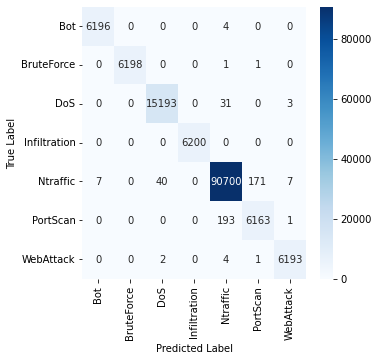

Execution Time: 52.795825242996216 seconds


In [58]:
import time

# Record the starting time
start_time = time.time()
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
#print(classification_report(y_true,y_predict))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()
# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")